# Intro

This is a scratchpad for my ideas before I start coding the actual API and client.


## Graph specifications
* For a given set of SDKs ($s_1$, $s_2$ ... $s_n$) we have a matrix $M_{n+1\times n+1}$ where the entries are defined as
    * On the main diagonal $m_{i i}$ is the number of current apps are using each SDK
    * The other entries $m_{i j}$ correspond to how many apps switched from SDK $s_i$ to SDK $s_j$ (the churn rate).
    * The last line/column $m_{...n+1}$ and $m_{n+1...}$ correspond to apps that don't use any of the selected SDKs.
    * Remark: for the churn rates, the graph makes more sense if the SDKs we're comparing have the same purpose, otherwise it seems to me we might get strange results (e.g. both are installed at the same time). 
        * Example, there are 55 apps with more than one SDK from Stripe, Braintree and Paypal, and 3 apps that have all 3 SDKs installed.
        * Maybe we can try coding something that would warn the user if this happens.

## About the DB
* I'm assuming that in `app_sdk`, when `installed=0` it means that the SDK was installed previously and isn't anymore.

### Specifications for the queries
#### Except for the last line/column
* Main diagonal $s_{i i}$: count of all apps where `sdk=`$s_i$ and `installed=1`
* Churn rates $s_{i j}$: count of all apps where `sdk=`$s_i$ and `installed=0` and `sdk=`$s_j$ and `installed=1`
#### Last line/column
* Churn to (none) $s_{i n+1}$: count of all apps where `sdk=`$s_i$ and `installed=0` and there is no entry with `installed=1` and `sdk` among the chosen SDKs. (sorry for the confusing wording)
* Churn from (none) $s_{n+1 i}$ count of all apps where `sdk=`$s_i$ and `installed=1` and there is no entry with `installed=0` and `sdk` among the chosen SDKs.
* Last cell $s_{n+1 n+1}$: count of all apps where there no entry for any of the chosen SDKs.

# Roadmap

* Write the queries
* Reproduce the graph with matplotlib so I have a benchmark
* Write the API (probably use FastAPI and prepared SQL -- maybe use SqlALchemy)
* Write the client (plain old javascript with SVG, hopefuly)


# Remarks
* To pass the list of chosen SDKs to the queries, I have chosen to load their slugs into a temporary table called `slugs_to_query`.
* I have written 5 different queries for (i) churn between chosen sdks (ii and iii) churn to/from "none", (iv) apps never having used the chosen SDKS and (v) total SDK installation count.
* The queries are rather big/ugly and maybe could be rewritten and/or combined to rely on each other or reduce redundancy.

In [2]:
import sqlite3
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [130]:
con = sqlite3.connect("data.db")
cur = con.cursor()

app_df = pd.read_sql_query("SELECT * FROM app", con)
sdk_df = pd.read_sql_query("SELECT * FROM sdk", con)
app_sdk_df = pd.read_sql_query("SELECT * FROM app_sdk", con)

sdk_df

,id,name,slug,url,description
0,131,Umeng MobClick,umeng-mobclick,http://www.umeng.com/,None
1,33,PayPal,paypal,https://developer.paypal.com/webapps/developer...,Accept credit cards and PayPal in your iOS app.
2,262,card.io,card-io,https://www.card.io/,Credit card scanning for mobile apps.
3,18,Chartboost,chartboost,https://chartboost.com/,ChartboostSDK for showing ads and more.
4,51,AppLovin,applovin,https://github.com/BlueRiverInteractive/robovm...,Advertisers:\r\nReach Your Mobile Audience in ...
5,1029,PaymentKit,paymentkit,https://stripe.com,Utility library for creating credit card payme...
6,30,RevMob,revmob,http://sdk.revmob.com/ios.html,"RevMobSDK for showing ads, banners, more games..."
7,6075,Alipay,alipay,None,None
8,2081,Braintree,braintree,https://braintreepayments.com/,The Braintree API helps businesses accept paym...
9,8,Flurry,flurry,http://www.flurry.com,Flurry SDK for analytics tracking and reportin...


In [131]:
sdk_choice = "paypal braintree stripe".split() # slugs

try:
  cur.execute('DROP TABLE slugs_to_query')
except:
  pass
try:
  cur.execute('CREATE TABLE slugs_to_query(slug)')
except:
  pass
cur.executemany('INSERT INTO slugs_to_query(slug) VALUES (?)', [(slug,) for slug in sdk_choice])

In [79]:
# Find churn between chosen SDKs

churn_main = pd.read_sql_query(
  """
  
  SELECT 
    T1.sdk_id as sdk_id_from,
    sdk1.slug as sdk_slug_from,
    T2.sdk_id as sdk_id_to,
    sdk2.slug as sdk_slug_to,
    COUNT(T1.app_id) as qty
    
  FROM app_sdk T1, app_sdk T2 -- Cartesian product of all possible to/from pairs
  
  JOIN sdk as sdk1 -- add SDK data for "from" sdk
  ON T1.sdk_id = sdk1.id
  
  JOIN sdk as sdk2 -- add SDK data for "to" sdk
  ON T2.sdk_id = sdk2.id
  
  JOIN slugs_to_query as query1 -- restrict "from" sdks to our query
  ON query1.slug = sdk1.slug
  
  JOIN slugs_to_query as query2  -- restrict "to" sdks to our query
  ON query2.slug = sdk2.slug
  
  WHERE T1.app_id = T2.app_id -- only match when app_id matches
  AND T1.installed = 0 -- "from" should not be installed
  AND T2.installed = 1 -- "to" should be installed

  GROUP BY sdk_id_from, sdk_id_to -- Group by to/from pairs
  """, con)

churn_main

,sdk_id_from,sdk_slug_from,sdk_id_to,sdk_slug_to,qty
0,33,paypal,875,stripe,20
1,33,paypal,2081,braintree,48
2,875,stripe,33,paypal,1
3,875,stripe,2081,braintree,6
4,2081,braintree,33,paypal,11
5,2081,braintree,875,stripe,12


In [100]:
# Find churn from chosen SDKs *to* None


churn_to_none = pd.read_sql_query(
  """
  
  SELECT 
    T1.sdk_id as sdk_id_from,
    sdk1.slug as sdk_slug_from,
    COUNT(DISTINCT T1.app_id) as qty
    
  FROM app_sdk T1, app_sdk T2 -- Cartesian product of all possible to/from pairs
  
  JOIN sdk as sdk1 -- add SDK data for "from" sdk
  ON T1.sdk_id = sdk1.id
  
  JOIN sdk as sdk2 -- add SDK data for "to" sdk
  ON T2.sdk_id = sdk2.id
  
  JOIN slugs_to_query as query1 -- restrict "from" sdks to our query
  ON query1.slug = sdk1.slug
  
  WHERE T1.app_id = T2.app_id -- only match when app_id matches
  AND T1.installed = 0 -- "from" should not be installed
  AND T2.installed = 1 -- "to" should be installed
  AND NOT EXISTS (
    SELECT *
    FROM slugs_to_query query2
    WHERE sdk2.slug == query2.slug
  )
  
  GROUP BY sdk_id_from -- Group by "from"
  """, con)

churn_to_none

,sdk_id_from,sdk_slug_from,qty
0,33,paypal,139
1,875,stripe,50
2,2081,braintree,51


In [81]:
# Find churn from chosen SDKs *from* None

churn_from_none = pd.read_sql_query(
  """
  
  SELECT 
    T2.sdk_id as sdk_id_to,
    sdk2.slug as sdk_slug_to,
    COUNT(DISTINCT T1.app_id) as qty
    
  FROM app_sdk T1, app_sdk T2 -- Cartesian product of all possible to/from pairs
  
  JOIN sdk as sdk1 -- add SDK data for "from" sdk
  ON T1.sdk_id = sdk1.id
  
  JOIN sdk as sdk2 -- add SDK data for "to" sdk
  ON T2.sdk_id = sdk2.id
  
  JOIN slugs_to_query as query1 -- restrict "to" sdks to our query
  ON query1.slug = sdk2.slug
  
  WHERE T1.app_id = T2.app_id -- only match when app_id matches
  AND T1.installed = 0 -- "from" should not be installed
  AND T2.installed = 1 -- "to" should be installed
  AND NOT EXISTS (
    SELECT *
    FROM slugs_to_query query2
    WHERE sdk1.slug == query2.slug
  )
  
  GROUP BY sdk_id_to -- Group by "to"
  """, con)

churn_from_none

,sdk_id_to,sdk_slug_to,qty
0,33,paypal,47
1,875,stripe,121
2,2081,braintree,80


In [164]:
# Count apps that never used chosen SDKs (None/None)

not_involved = pd.read_sql_query(
  """
  SELECT COUNT(*) as qty
  FROM app
  WHERE NOT EXISTS(
      SELECT * FROM app_sdk -- get all installation data
      
      JOIN sdk ON app_sdk.sdk_id = sdk.id -- get sdk info
      JOIN slugs_to_query ON sdk.slug = slugs_to_query.slug -- get choice of sdks
      
      WHERE app_sdk.installed = 1 -- must be installed
      AND app_sdk.app_id = app.id -- ID must match
  )  
  """, con)

not_involved

,qty
0,9657


In [149]:
# Find SDK totals

totals = pd.read_sql_query(
  """
  SELECT sdk.slug, COUNT(T.app_id) as qty FROM app_sdk T
  
  JOIN sdk
  ON T.sdk_id = sdk.id
  
  JOIN slugs_to_query as q
  ON q.slug = sdk.slug
  
  WHERE T.installed = 1 -- should be installed
  
  GROUP BY sdk.id 
  """, con)

totals

,slug,qty
0,paypal,84
1,stripe,172
2,braintree,145


In [161]:
# This is just a sanity check

multiple = pd.read_sql_query(
"""
  SELECT SUM(extra) FROM (
    SELECT app_sdk.app_id, count(app_sdk.app_id)-1 as extra FROM app_sdk

    JOIN sdk ON app_sdk.sdk_id = sdk.id
    JOIN slugs_to_query ON sdk.slug = slugs_to_query.slug
    WHERE app_sdk.installed=1
    
    GROUP BY app_sdk.app_id HAVING extra > 0
  )
""", con)

assert (
  not_involved.to_numpy()[0, 0] # All the apps that didn't make the selection
  + totals.qty.sum() # PLUS all the totals for each selected SDK
  - multiple.to_numpy()[0, 0] # MINUS all the extra SDKs from apple that have more than one SDK
  == len(app_df) # MUST EQUAL the total number of apps in the sample
)

In [165]:
labels = [*sdk_choice, "None"]

matrix = pd.DataFrame(columns=labels, index = labels)

matrix["None"]["None"] = not_involved.qty.array[0]

for sdk_1 in sdk_choice:
  
  # Totals
  select = totals.slug == sdk_1
  matrix[sdk_1][sdk_1] = totals[select].qty.array[0]
  
  # To None
  select = churn_to_none.sdk_slug_from == sdk_1
  matrix["None"][sdk_1]  = churn_to_none[select].qty.array[0]
  
  # From None
  select = churn_from_none.sdk_slug_to == sdk_1
  matrix[sdk_1]["None"]  = churn_from_none[select].qty.array[0]
  
  # Rest of churn
  
  for sdk_2 in sdk_choice:
    if sdk_1!=sdk_2:
      select = (churn_main.sdk_slug_from == sdk_1) & (churn_main.sdk_slug_to == sdk_2)
      matrix[sdk_2][sdk_1] = churn_main[select].qty.array[0]
matrix

,paypal,braintree,stripe,None
paypal,84,48,20,139
braintree,11,145,12,51
stripe,1,6,172,50
None,47,80,121,9657


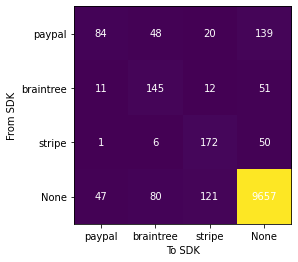

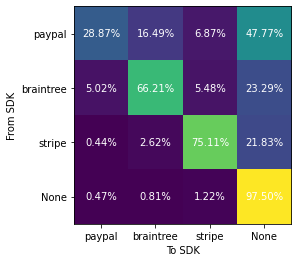

In [166]:
# Got help from:
# https://stackoverflow.com/a/35679163/9116169
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()

im = ax.imshow(
   matrix.to_numpy(dtype=float)
)


# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_ylabel("From SDK")
ax.set_xlabel("To SDK")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(
          j, i, matrix.to_numpy()[i, j],
          ha="center", va="center", color="w"
        )



fig, ax = plt.subplots()

normalized = matrix.div(matrix.sum(axis=1), axis=0).to_numpy(dtype=float)
im = ax.imshow(
  normalized
)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_ylabel("From SDK")
ax.set_xlabel("To SDK")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(
          j, i, f"{100*normalized[i, j]:.2f}%",
          ha="center", va="center", color="w"
        )

In [6]:
con.close()

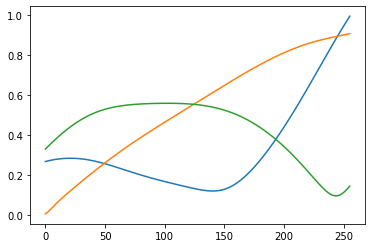

In [170]:
cividis = [
    [0.0000, 0.1262, 0.3015],
    [0.0000, 0.1292, 0.3077],
    [0.0000, 0.1321, 0.3142],
    [0.0000, 0.1350, 0.3205],
    [0.0000, 0.1379, 0.3269],
    [0.0000, 0.1408, 0.3334],
    [0.0000, 0.1437, 0.3400],
    [0.0000, 0.1465, 0.3467],
    [0.0000, 0.1492, 0.3537],
    [0.0000, 0.1519, 0.3606],
    [0.0000, 0.1546, 0.3676],
    [0.0000, 0.1574, 0.3746],
    [0.0000, 0.1601, 0.3817],
    [0.0000, 0.1629, 0.3888],
    [0.0000, 0.1657, 0.3960],
    [0.0000, 0.1685, 0.4031],
    [0.0000, 0.1714, 0.4102],
    [0.0000, 0.1743, 0.4172],
    [0.0000, 0.1773, 0.4241],
    [0.0000, 0.1798, 0.4307],
    [0.0000, 0.1817, 0.4347],
    [0.0000, 0.1834, 0.4363],
    [0.0000, 0.1852, 0.4368],
    [0.0000, 0.1872, 0.4368],
    [0.0000, 0.1901, 0.4365],
    [0.0000, 0.1930, 0.4361],
    [0.0000, 0.1958, 0.4356],
    [0.0000, 0.1987, 0.4349],
    [0.0000, 0.2015, 0.4343],
    [0.0000, 0.2044, 0.4336],
    [0.0000, 0.2073, 0.4329],
    [0.0055, 0.2101, 0.4322],
    [0.0236, 0.2130, 0.4314],
    [0.0416, 0.2158, 0.4308],
    [0.0576, 0.2187, 0.4301],
    [0.0710, 0.2215, 0.4293],
    [0.0827, 0.2244, 0.4287],
    [0.0932, 0.2272, 0.4280],
    [0.1030, 0.2300, 0.4274],
    [0.1120, 0.2329, 0.4268],
    [0.1204, 0.2357, 0.4262],
    [0.1283, 0.2385, 0.4256],
    [0.1359, 0.2414, 0.4251],
    [0.1431, 0.2442, 0.4245],
    [0.1500, 0.2470, 0.4241],
    [0.1566, 0.2498, 0.4236],
    [0.1630, 0.2526, 0.4232],
    [0.1692, 0.2555, 0.4228],
    [0.1752, 0.2583, 0.4224],
    [0.1811, 0.2611, 0.4220],
    [0.1868, 0.2639, 0.4217],
    [0.1923, 0.2667, 0.4214],
    [0.1977, 0.2695, 0.4212],
    [0.2030, 0.2723, 0.4209],
    [0.2082, 0.2751, 0.4207],
    [0.2133, 0.2780, 0.4205],
    [0.2183, 0.2808, 0.4204],
    [0.2232, 0.2836, 0.4203],
    [0.2281, 0.2864, 0.4202],
    [0.2328, 0.2892, 0.4201],
    [0.2375, 0.2920, 0.4200],
    [0.2421, 0.2948, 0.4200],
    [0.2466, 0.2976, 0.4200],
    [0.2511, 0.3004, 0.4201],
    [0.2556, 0.3032, 0.4201],
    [0.2599, 0.3060, 0.4202],
    [0.2643, 0.3088, 0.4203],
    [0.2686, 0.3116, 0.4205],
    [0.2728, 0.3144, 0.4206],
    [0.2770, 0.3172, 0.4208],
    [0.2811, 0.3200, 0.4210],
    [0.2853, 0.3228, 0.4212],
    [0.2894, 0.3256, 0.4215],
    [0.2934, 0.3284, 0.4218],
    [0.2974, 0.3312, 0.4221],
    [0.3014, 0.3340, 0.4224],
    [0.3054, 0.3368, 0.4227],
    [0.3093, 0.3396, 0.4231],
    [0.3132, 0.3424, 0.4236],
    [0.3170, 0.3453, 0.4240],
    [0.3209, 0.3481, 0.4244],
    [0.3247, 0.3509, 0.4249],
    [0.3285, 0.3537, 0.4254],
    [0.3323, 0.3565, 0.4259],
    [0.3361, 0.3593, 0.4264],
    [0.3398, 0.3622, 0.4270],
    [0.3435, 0.3650, 0.4276],
    [0.3472, 0.3678, 0.4282],
    [0.3509, 0.3706, 0.4288],
    [0.3546, 0.3734, 0.4294],
    [0.3582, 0.3763, 0.4302],
    [0.3619, 0.3791, 0.4308],
    [0.3655, 0.3819, 0.4316],
    [0.3691, 0.3848, 0.4322],
    [0.3727, 0.3876, 0.4331],
    [0.3763, 0.3904, 0.4338],
    [0.3798, 0.3933, 0.4346],
    [0.3834, 0.3961, 0.4355],
    [0.3869, 0.3990, 0.4364],
    [0.3905, 0.4018, 0.4372],
    [0.3940, 0.4047, 0.4381],
    [0.3975, 0.4075, 0.4390],
    [0.4010, 0.4104, 0.4400],
    [0.4045, 0.4132, 0.4409],
    [0.4080, 0.4161, 0.4419],
    [0.4114, 0.4189, 0.4430],
    [0.4149, 0.4218, 0.4440],
    [0.4183, 0.4247, 0.4450],
    [0.4218, 0.4275, 0.4462],
    [0.4252, 0.4304, 0.4473],
    [0.4286, 0.4333, 0.4485],
    [0.4320, 0.4362, 0.4496],
    [0.4354, 0.4390, 0.4508],
    [0.4388, 0.4419, 0.4521],
    [0.4422, 0.4448, 0.4534],
    [0.4456, 0.4477, 0.4547],
    [0.4489, 0.4506, 0.4561],
    [0.4523, 0.4535, 0.4575],
    [0.4556, 0.4564, 0.4589],
    [0.4589, 0.4593, 0.4604],
    [0.4622, 0.4622, 0.4620],
    [0.4656, 0.4651, 0.4635],
    [0.4689, 0.4680, 0.4650],
    [0.4722, 0.4709, 0.4665],
    [0.4756, 0.4738, 0.4679],
    [0.4790, 0.4767, 0.4691],
    [0.4825, 0.4797, 0.4701],
    [0.4861, 0.4826, 0.4707],
    [0.4897, 0.4856, 0.4714],
    [0.4934, 0.4886, 0.4719],
    [0.4971, 0.4915, 0.4723],
    [0.5008, 0.4945, 0.4727],
    [0.5045, 0.4975, 0.4730],
    [0.5083, 0.5005, 0.4732],
    [0.5121, 0.5035, 0.4734],
    [0.5158, 0.5065, 0.4736],
    [0.5196, 0.5095, 0.4737],
    [0.5234, 0.5125, 0.4738],
    [0.5272, 0.5155, 0.4739],
    [0.5310, 0.5186, 0.4739],
    [0.5349, 0.5216, 0.4738],
    [0.5387, 0.5246, 0.4739],
    [0.5425, 0.5277, 0.4738],
    [0.5464, 0.5307, 0.4736],
    [0.5502, 0.5338, 0.4735],
    [0.5541, 0.5368, 0.4733],
    [0.5579, 0.5399, 0.4732],
    [0.5618, 0.5430, 0.4729],
    [0.5657, 0.5461, 0.4727],
    [0.5696, 0.5491, 0.4723],
    [0.5735, 0.5522, 0.4720],
    [0.5774, 0.5553, 0.4717],
    [0.5813, 0.5584, 0.4714],
    [0.5852, 0.5615, 0.4709],
    [0.5892, 0.5646, 0.4705],
    [0.5931, 0.5678, 0.4701],
    [0.5970, 0.5709, 0.4696],
    [0.6010, 0.5740, 0.4691],
    [0.6050, 0.5772, 0.4685],
    [0.6089, 0.5803, 0.4680],
    [0.6129, 0.5835, 0.4673],
    [0.6168, 0.5866, 0.4668],
    [0.6208, 0.5898, 0.4662],
    [0.6248, 0.5929, 0.4655],
    [0.6288, 0.5961, 0.4649],
    [0.6328, 0.5993, 0.4641],
    [0.6368, 0.6025, 0.4632],
    [0.6408, 0.6057, 0.4625],
    [0.6449, 0.6089, 0.4617],
    [0.6489, 0.6121, 0.4609],
    [0.6529, 0.6153, 0.4600],
    [0.6570, 0.6185, 0.4591],
    [0.6610, 0.6217, 0.4583],
    [0.6651, 0.6250, 0.4573],
    [0.6691, 0.6282, 0.4562],
    [0.6732, 0.6315, 0.4553],
    [0.6773, 0.6347, 0.4543],
    [0.6813, 0.6380, 0.4532],
    [0.6854, 0.6412, 0.4521],
    [0.6895, 0.6445, 0.4511],
    [0.6936, 0.6478, 0.4499],
    [0.6977, 0.6511, 0.4487],
    [0.7018, 0.6544, 0.4475],
    [0.7060, 0.6577, 0.4463],
    [0.7101, 0.6610, 0.4450],
    [0.7142, 0.6643, 0.4437],
    [0.7184, 0.6676, 0.4424],
    [0.7225, 0.6710, 0.4409],
    [0.7267, 0.6743, 0.4396],
    [0.7308, 0.6776, 0.4382],
    [0.7350, 0.6810, 0.4368],
    [0.7392, 0.6844, 0.4352],
    [0.7434, 0.6877, 0.4338],
    [0.7476, 0.6911, 0.4322],
    [0.7518, 0.6945, 0.4307],
    [0.7560, 0.6979, 0.4290],
    [0.7602, 0.7013, 0.4273],
    [0.7644, 0.7047, 0.4258],
    [0.7686, 0.7081, 0.4241],
    [0.7729, 0.7115, 0.4223],
    [0.7771, 0.7150, 0.4205],
    [0.7814, 0.7184, 0.4188],
    [0.7856, 0.7218, 0.4168],
    [0.7899, 0.7253, 0.4150],
    [0.7942, 0.7288, 0.4129],
    [0.7985, 0.7322, 0.4111],
    [0.8027, 0.7357, 0.4090],
    [0.8070, 0.7392, 0.4070],
    [0.8114, 0.7427, 0.4049],
    [0.8157, 0.7462, 0.4028],
    [0.8200, 0.7497, 0.4007],
    [0.8243, 0.7532, 0.3984],
    [0.8287, 0.7568, 0.3961],
    [0.8330, 0.7603, 0.3938],
    [0.8374, 0.7639, 0.3915],
    [0.8417, 0.7674, 0.3892],
    [0.8461, 0.7710, 0.3869],
    [0.8505, 0.7745, 0.3843],
    [0.8548, 0.7781, 0.3818],
    [0.8592, 0.7817, 0.3793],
    [0.8636, 0.7853, 0.3766],
    [0.8681, 0.7889, 0.3739],
    [0.8725, 0.7926, 0.3712],
    [0.8769, 0.7962, 0.3684],
    [0.8813, 0.7998, 0.3657],
    [0.8858, 0.8035, 0.3627],
    [0.8902, 0.8071, 0.3599],
    [0.8947, 0.8108, 0.3569],
    [0.8992, 0.8145, 0.3538],
    [0.9037, 0.8182, 0.3507],
    [0.9082, 0.8219, 0.3474],
    [0.9127, 0.8256, 0.3442],
    [0.9172, 0.8293, 0.3409],
    [0.9217, 0.8330, 0.3374],
    [0.9262, 0.8367, 0.3340],
    [0.9308, 0.8405, 0.3306],
    [0.9353, 0.8442, 0.3268],
    [0.9399, 0.8480, 0.3232],
    [0.9444, 0.8518, 0.3195],
    [0.9490, 0.8556, 0.3155],
    [0.9536, 0.8593, 0.3116],
    [0.9582, 0.8632, 0.3076],
    [0.9628, 0.8670, 0.3034],
    [0.9674, 0.8708, 0.2990],
    [0.9721, 0.8746, 0.2947],
    [0.9767, 0.8785, 0.2901],
    [0.9814, 0.8823, 0.2856],
    [0.9860, 0.8862, 0.2807],
    [0.9907, 0.8901, 0.2759],
    [0.9954, 0.8940, 0.2708],
    [1.0000, 0.8979, 0.2655],
    [1.0000, 0.9018, 0.2600],
    [1.0000, 0.9057, 0.2593],
    [1.0000, 0.9094, 0.2634],
    [1.0000, 0.9131, 0.2680],
    [1.0000, 0.9169, 0.2731]
]

In [176]:
[ "#"+"".join(f"{int(255*color):02x}" for color in swatch) for swatch in cividis]

['#00204c',
 '#00204e',
 '#002150',
 '#002251',
 '#002353',
 '#002355',
 '#002456',
 '#002558',
 '#00265a',
 '#00265b',
 '#00275d',
 '#00285f',
 '#002861',
 '#002963',
 '#002a64',
 '#002a66',
 '#002b68',
 '#002c6a',
 '#002d6c',
 '#002d6d',
 '#002e6e',
 '#002e6f',
 '#002f6f',
 '#002f6f',
 '#00306f',
 '#00316f',
 '#00316f',
 '#00326e',
 '#00336e',
 '#00346e',
 '#00346e',
 '#01356e',
 '#06366e',
 '#0a376d',
 '#0e376d',
 '#12386d',
 '#15396d',
 '#17396d',
 '#1a3a6c',
 '#1c3b6c',
 '#1e3c6c',
 '#203c6c',
 '#223d6c',
 '#243e6c',
 '#263e6c',
 '#273f6c',
 '#29406b',
 '#2b416b',
 '#2c416b',
 '#2e426b',
 '#2f436b',
 '#31446b',
 '#32446b',
 '#33456b',
 '#35466b',
 '#36466b',
 '#37476b',
 '#38486b',
 '#3a496b',
 '#3b496b',
 '#3c4a6b',
 '#3d4b6b',
 '#3e4b6b',
 '#404c6b',
 '#414d6b',
 '#424e6b',
 '#434e6b',
 '#444f6b',
 '#45506b',
 '#46506b',
 '#47516b',
 '#48526b',
 '#49536b',
 '#4a536b',
 '#4b546b',
 '#4c556b',
 '#4d556b',
 '#4e566b',
 '#4f576c',
 '#50586c',
 '#51586c',
 '#52596c',
 '#535a6c',
 '#5